## Between-meter associations (unsupervised, distance-based)

We start at:  

1) raking equal metrical forms per each meter (2 by default)  
2) taking random sample of poems per each form (150 by default)  
3) aggregating gamma  
4) calculating distances between samples  
5) hierarchical clustering  
6) check clusterization performance (purity & ARI)  
7) repeat 100 times per metrical forms arrangement, sample metrical forms 20 times  

If ARI shows above random, then some level of "within family" association is happening



Build consensus tree without strict per-family forms limits -> 200 poems as metrical sample and build trees 100 times -> see how trees agree in the end

In [3]:
### load libraries & data
#core
library(topicmodels)
library(tidytext)
library(tidyverse)
library(stringi)
#calculations
library(proxy)
library(ineq)
library(mclust)
#trees
library(ggtree)
library(ape)
library(phylogram)
library(ggdendro)
#visuals
library(paletteer)
library(ggrepel)
library(ggmosaic)
library(hrbrthemes)
library(plotly)
library(DT)
library(grid)



source("src/poem_sampler.R")
source("src/test_clusters_families.R") #depends on poem_sampler

load("data/lda_output.rda")

options(repr.plot.width = 8, repr.plot.height = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.1     ✔ purrr   0.3.3
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘proxy’


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


Package 'mclust' version 5.4.6
Type 'citation("mclust")' for citing this R package in publications.


Attaching package: ‘mclust’


The following object is masked from ‘package:purrr’:

    map


Registered S3 method overwritten by 'treeio':
  method     from
  root.phylo ape 

ggtree v2.0.4  For help: https://yulab-smu.github.io/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

- Guan

## Controlled clustering clean

Run clusterization checks on equal meter numbers per family (k=5, n=10)

1) Sample 2 meters per family randomly, get a set of equal cases per class  
2) For each set run 100 iterations to sample poems for each meter and measure mean clusterization strength.  
3) Repeat 1-2 for randomly allocated labels / randomly assigned clusters.


In [3]:
source("src/test_clusters_families.R")
clust_res = test_clusters_families(n_sample_families= 20,# how many times sample meter families
                                  n_families=2,# how many meters in one family to consider
                                  n_meters=2,# how many meters per family to take
                                  iterations=100,# how many times calculate clusters 
                                  min_meter_count=350,# limit for availiable poems per meter
                                  n_poems_per_sample=300,# how many poems in sample
                                  samples=1)# number of samples per meter

[1] "Now at 1 batch"


Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy



[1] "Now at 2 batch"
[1] "Now at 3 batch"
[1] "Now at 4 batch"
[1] "Now at 5 batch"
[1] "Now at 6 batch"
[1] "Now at 7 batch"
[1] "Now at 8 batch"
[1] "Now at 9 batch"
[1] "Now at 10 batch"
[1] "Now at 11 batch"
[1] "Now at 12 batch"
[1] "Now at 13 batch"
[1] "Now at 14 batch"
[1] "Now at 15 batch"
[1] "Now at 16 batch"
[1] "Now at 17 batch"
[1] "Now at 18 batch"
[1] "Now at 19 batch"
[1] "Now at 20 batch"


In [7]:

clust_res = clust_res %>%
    mutate(random = FALSE)
clust_res  %>% summarise(m_ari=median(ari), m_pur=median(purity))

m_ari,m_pur
<dbl>,<dbl>
0.465608,0.77875


In [8]:
source("src/test_clusters_families.R")
clust_res_random = test_clusters_families(n_sample_families= 20,
                                  n_families=2,
                                  n_meters=2,
                                  iterations=100,
                                  min_meter_count=350,
                                  n_poems_per_sample=300,
                                  samples=1,
                                  random_clusters=T) # rearrange clusters randomly

[1] "Now at 1 batch"
[1] "Now at 2 batch"
[1] "Now at 3 batch"
[1] "Now at 4 batch"
[1] "Now at 5 batch"
[1] "Now at 6 batch"
[1] "Now at 7 batch"
[1] "Now at 8 batch"
[1] "Now at 9 batch"
[1] "Now at 10 batch"
[1] "Now at 11 batch"
[1] "Now at 12 batch"
[1] "Now at 13 batch"
[1] "Now at 14 batch"
[1] "Now at 15 batch"
[1] "Now at 16 batch"
[1] "Now at 17 batch"
[1] "Now at 18 batch"
[1] "Now at 19 batch"
[1] "Now at 20 batch"


In [9]:
clust_res_random = clust_res_random %>%
    mutate(random = TRUE)  %>% 
    rename



In [10]:
save(clust_res_random, clust_res, file="data/clust_res.rda")

In [4]:
load("data/clust_res.rda")
ari_between = clust_res  %>% 
    mutate(ari_rand = clust_res_random$ari,
           purity_rand = clust_res_random$purity)  %>% 
    select(-random)  %>% 
    gather(key="cluster", value=n)  %>% 
    mutate(random = case_when(str_detect(cluster, "rand") ~ TRUE,
                              !str_detect(cluster, "rand") ~ FALSE))  %>%
    mutate(cluster=fct_relevel(cluster, "ari_rand", "ari" ,"purity_rand", "purity"))  %>% 
    ggplot(aes(cluster, n, group=cluster, color=random)) + geom_boxplot() + theme_ipsum() + labs(x="", y="Value",title="a") + theme(axis.title.x = element_text(size=12),
                                                                   axis.title.y = element_text(size=12),
                                                                   plot.margin  = margin(0,0,0,0)) + scale_color_paletteer_d("ghibli::MononokeMedium",direction = 1) + guides(color=F)

## Consensus tree

test how robust are between-meter semantic associations without limitation of forms per meter

1) batch build trees, random sampling from the same meters  
2) take trees and see how do they agree on clustering  
3) majority-rule consensus tree (at least 50% of times branches agree)  

In [6]:
source("src/consensus_tree_halo.R") # depends on poem_sampler.R

trees = consensus_tree_halo(x=unique_poems,
                    y=meter_count,
                    z=ru_gamma_separated,
                    sample_size = 300,
                    n_samples=100,
                    min_meter_count=350,
                    distance="Kullback",
                    clust_method="ward.D2")

In [18]:
# unrooted consesus
trans = translation  %>% rename(label = meter)

consensus = ape::consensus(trees, p=0.5)



plot=ggtree(consensus,layout="circular",size=0.5) 
plot$data = plot$data  %>%
         mutate(class = str_replace_all(label, "^(.*?)\\d.*", "\\1"),
               class = str_replace_all(class,"Явольн", "Я"))  %>% 
         left_join(trans, by="label")  %>% 
         mutate(label = case_when(!is.na(label) ~ meter_eng))
cons_between = plot +geom_tiplab(aes(color=class),hjust=-.1,size=3) + guides(color=F) +
 scale_color_manual(values=c(rep(paletteer_d("ghibli::MononokeMedium"),2))) + labs(title="b") + xlim(0,4.5)

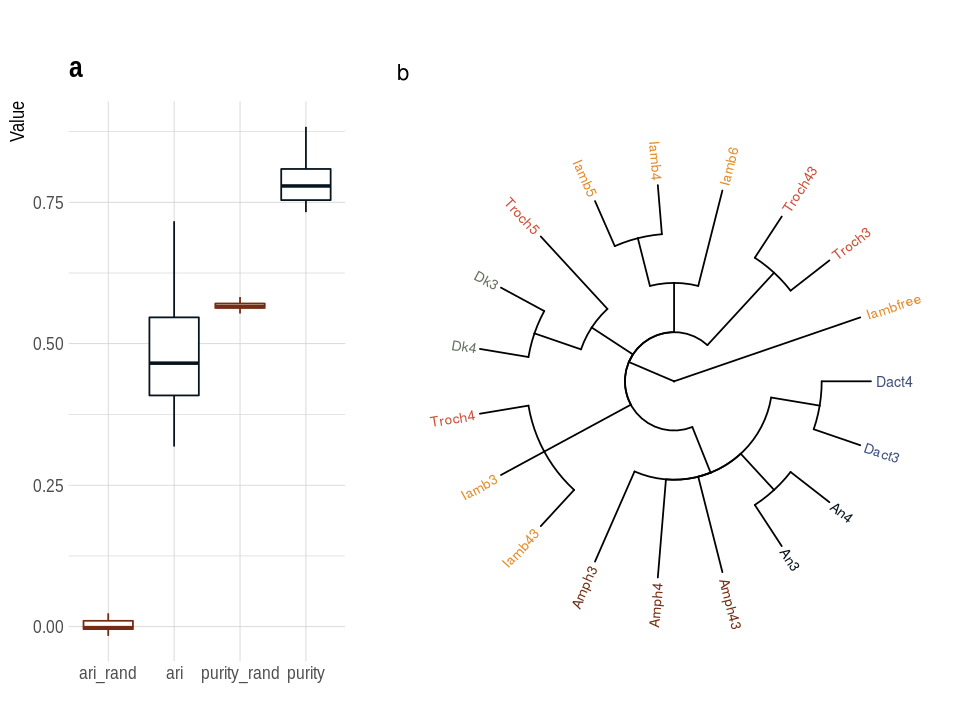

In [19]:
library(patchwork)

layout <- "
AABBBB
AABBBB"

ari_between + cons_between +theme(plot.margin =  margin(1, 0, 0, 1, "cm")) + plot_layout(design = layout)

ggsave("plots/fig3_between.png", width = 8, height = 4)

## Code backyard

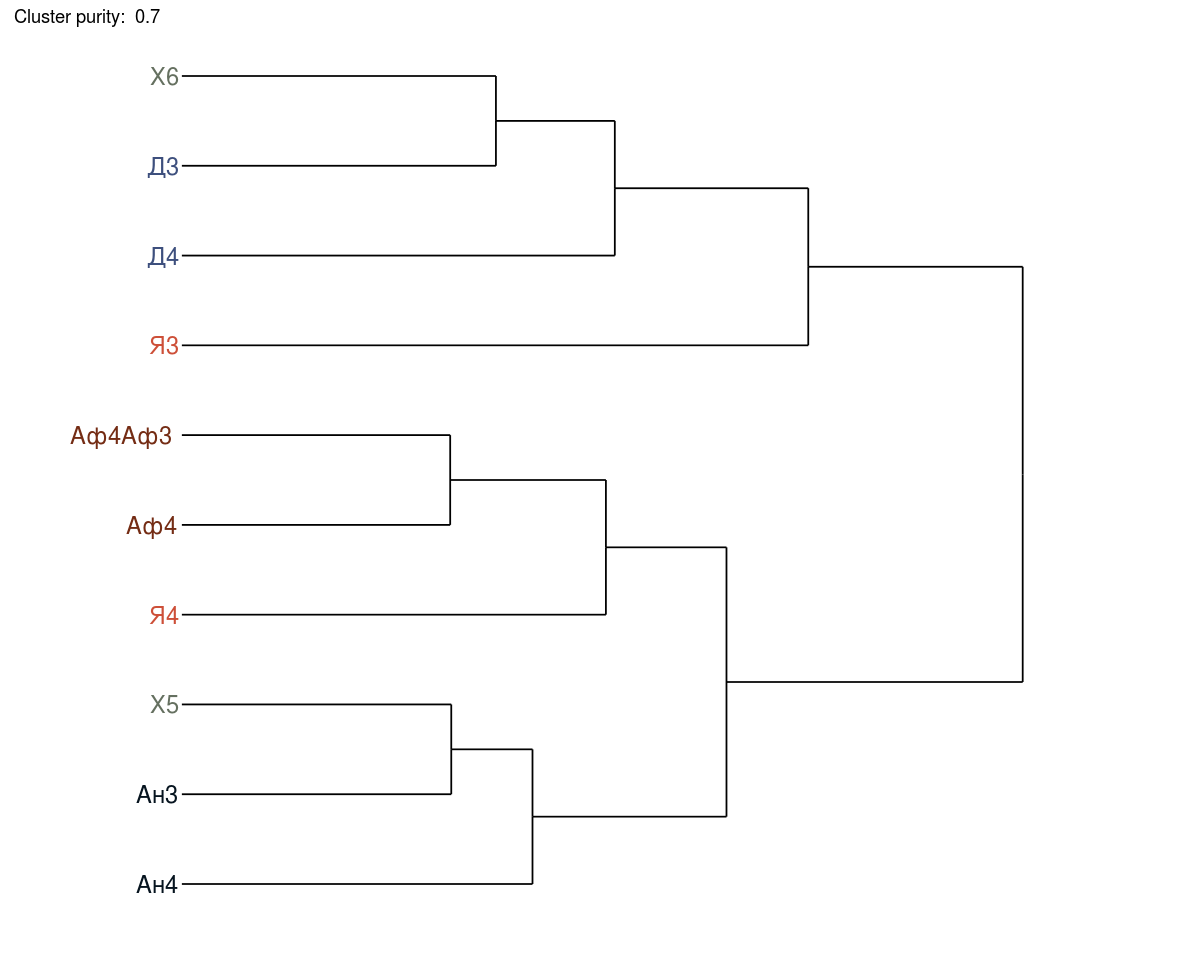

In [190]:
ggtree = tree  %>%
    as.dendrogram() %>%
    dendro_data()

ggtree$labels = ggtree$labels %>%
  mutate(m_family = str_replace(label, "^(.*?)\\d.*", "\\1"),
         m_family = str_replace(m_family, "Явольн", "Я"))

ggplot() +
  geom_segment(data=ggtree$segments,aes(x,y,xend=xend, yend=yend),size=0.5) + # map segments/branches
  geom_text(data=ggtree$labels, aes(x,y,label=label, color=m_family), hjust=1.1, angle=0, size=5) + # map labels
  coord_flip() +
  scale_y_continuous(expand=c(0.2, 0)) +
  theme_dendro() +
  scale_color_paletteer_d("ghibli::MononokeMedium") +
  guides(color=F) +
  labs(subtitle=paste("Cluster purity: ", round(purity,2)))